# Load Packages

In [7]:
import numpy as np
import pandas as pd
from scipy import stats

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

# Pipeline
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

# Model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import Ridge, Lasso, LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeRegressor

from sklearn import set_config
# set_config(display='diagram')

import warnings
# warnings.filterwarnings('ignore')

# Load Data

## Load RAW data

In [8]:
# set data source
data_url = 'data/train.csv'

# set index column
index_col = 'PassengerId'

# load data
data = pd.read_csv(data_url, index_col=index_col)
data.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Feature-Target split

In [9]:
# define the target column in the train dataset
target = 'Survived'

# split columns into X and y
X = data.drop(columns = target).copy()
y = data[target]

# check the shape of the data
print(f'shape of X is \033[94m{X.shape}\033[0m, shape of y is \033[94m{y.shape}\033[0m')

shape of X is (891, 10), shape of y is (891,)


## Missing values

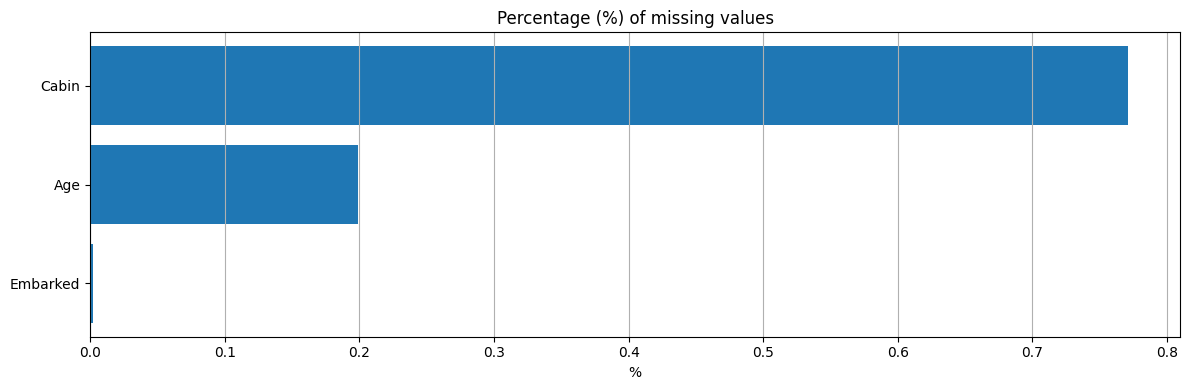

In [52]:
#filter all the features with missing values
feature_null= X.isnull().mean().sort_values(ascending = False)
feature_null=feature_null[feature_null>0]

# visualize
plt.figure(figsize=(12, 4))
feature_ranks = range(len(feature_null))
bar = plt.barh(feature_null.index, feature_null.values, label=[str(x) for x in feature_ranks])
plt.gca().invert_yaxis()
plt.xlabel('%')
plt.title("Percentage (%) of missing values")
plt.tight_layout()
plt.grid(axis='x')
plt.show()

## Feature selection

In [ ]:
features_all = X.columns.to_list()
columns_to_drop = ['Name', 'Ticket', 'Cabin']

X = X.drop(columns=columns_to_drop)

feature_numerical = X.select_dtypes(exclude='object').columns.to_list()

feature_categorical = X.select_dtypes(include='object').columns.to_list()

feature_categorical_Ordinal = []

feature_categorical_OneHot = [key for key in feature_categorical 
                              if key not in feature_categorical_Ordinal]

print(f'All features (\033[94m{len(features_all)}\
\033[0m): \033[94m{features_all}\033[0m')

print(f'Features to drop (\033[91m{len(columns_to_drop)}\
\033[0m): \033[94m{columns_to_drop}\033[0m')

print(f'Numercial features (\033[94m{len(feature_numerical)}\
\033[0m): \033[94m{feature_numerical}\033[0m')

print(f'Categorical cat features (\033[94m{len(feature_categorical)}\
\033[0m): \033[94m{feature_categorical}\033[0m')

print(f'Ordinal cat features (\033[94m{len(feature_categorical_Ordinal)}\
\033[0m): \033[94m{feature_categorical_Ordinal}\033[0m')

print(f'None-ordinal cat features (\033[94m{len(feature_categorical_OneHot)}\
\033[0m): \033[94m{feature_categorical_OneHot}\033[0m')


# Data Exploration

## Distribution of each numerical feature

In [ ]:
X[feature_numerical].hist(
    figsize=(16, 20), 
    bins=50, 
    xlabelsize=8, 
    ylabelsize=8);

## Distribution of each catigorical feature

In [ ]:
# this need to be improved by a better way to support quick look
for column in feature_categorical:
    # Create a countplot
    plt.figure()
    sns.histplot(data=X, x=column, kde=True)
    plt.title(column + ' Histogram')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

# Data Preprocessing

In [ ]:
#transformer for numerical data
preproc_num = make_pipeline(
    SimpleImputer(strategy='mean'),
    MinMaxScaler()
)

preproc_cat_ordinal = make_pipeline(
    SimpleImputer(strategy='most_frequent')
)

preproc_cat_onehot = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(
        drop = 'if_binary',
        sparse_output=False,
        handle_unknown='ignore')
)

preproc_pipeline = make_column_transformer(
    (preproc_num, feature_numerical),
    (preproc_cat_ordinal, feature_categorical_Ordinal),
    (preproc_cat_onehot, feature_categorical_OneHot),
    remainder='passthrough'
)

display(preproc_pipeline)

In [ ]:
preproc_pipeline.fit(X)

# Model

## Cross validation

In [ ]:
cv_model = KNeighborsClassifier()
cv_baseline = make_pipeline(
    preproc_pipeline,
    cv_model
)

cv_result = cross_val_score(
    cv_baseline,
    X, 
    y, 
    cv=5,
#     scoring='',
    n_jobs=-1)
score_baseline=np.mean(cv_result)
print(f'Baseline score: \033[94m{score_baseline}\033[0m \nof {type(cv_model)} model ')

## Grid/Random Search

### KNN

In [ ]:
knn_pipeline = make_pipeline(
    preproc_pipeline, 
    KNeighborsRegressor()
)

knn_param_grid={
    '__n_neighbors': list(range(1,20,1))
}
knn_search = GridSearchCV(knn_pipeline, 
                      knn_param_grid, 
                      cv=5, 
                      scoring='r2', 
                      n_jobs=-1)
knn_search.fit(X, y)

In [ ]:
knn_best_model = knn_search.best_estimator_
print(knn_search.best_score_)
print(knn_search.best_params_)

### Random Foreast

### SVM